In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electric-vehicle-charging-patterns/ev_charging_patterns.csv


**Setup and Data Loading**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv("/kaggle/input/electric-vehicle-charging-patterns/ev_charging_patterns.csv")
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,User ID,Vehicle Model,Battery Capacity (kWh),Charging Station ID,Charging Station Location,Charging Start Time,Charging End Time,Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),Charging Cost (USD),Time of Day,Day of Week,State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years),Charger Type,User Type
0,User_1,BMW i3,108.463007,Station_391,Houston,2024-01-01 00:00:00,2024-01-01 00:39:00,60.712346,0.591363,36.389181,13.087717,Evening,Tuesday,29.371576,86.119962,293.602111,27.947953,2.0,DC Fast Charger,Commuter
1,User_2,Hyundai Kona,100.000000,Station_428,San Francisco,2024-01-01 01:00:00,2024-01-01 03:01:00,12.339275,3.133652,30.677735,21.128448,Morning,Monday,10.115778,84.664344,112.112804,14.311026,3.0,Level 1,Casual Driver
2,User_3,Chevy Bolt,75.000000,Station_181,San Francisco,2024-01-01 02:00:00,2024-01-01 04:48:00,19.128876,2.452653,27.513593,35.667270,Morning,Thursday,6.854604,69.917615,71.799253,21.002002,2.0,Level 2,Commuter
3,User_4,Hyundai Kona,50.000000,Station_327,Houston,2024-01-01 03:00:00,2024-01-01 06:42:00,79.457824,1.266431,32.882870,13.036239,Evening,Saturday,83.120003,99.624328,199.577785,38.316313,1.0,Level 1,Long-Distance Traveler
4,User_5,Hyundai Kona,50.000000,Station_108,Los Angeles,2024-01-01 04:00:00,2024-01-01 05:46:00,19.629104,2.019765,10.215712,10.161471,Morning,Saturday,54.258950,63.743786,203.661847,-7.834199,1.0,Level 1,Long-Distance Traveler


**Data Preprocessing**

In [4]:
print("\nMissing values in each column:")
print(df.isnull().sum())

numerical_cols = ['Battery Capacity (kWh)', 'Energy Consumed (kWh)', 'Charging Duration (hours)',
                  'Charging Rate (kW)', 'Charging Cost (USD)', 'State of Charge (Start %)',
                  'State of Charge (End %)', 'Distance Driven (since last charge) (km)',
                  'Temperature (°C)', 'Vehicle Age (years)']
categorical_cols = ['Vehicle Model', 'Charging Station Location', 'Time of Day',
                    'Day of Week', 'Charger Type', 'User Type']

for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)


Missing values in each column:
User ID                                      0
Vehicle Model                                0
Battery Capacity (kWh)                       0
Charging Station ID                          0
Charging Station Location                    0
Charging Start Time                          0
Charging End Time                            0
Energy Consumed (kWh)                       66
Charging Duration (hours)                    0
Charging Rate (kW)                          66
Charging Cost (USD)                          0
Time of Day                                  0
Day of Week                                  0
State of Charge (Start %)                    0
State of Charge (End %)                      0
Distance Driven (since last charge) (km)    66
Temperature (°C)                             0
Vehicle Age (years)                          0
Charger Type                                 0
User Type                                    0
dtype: int64


/tmp/ipykernel_18/1839051727.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_18/1839051727.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [5]:
df['Charging Start Time'] = pd.to_datetime(df['Charging Start Time'])
df['Charging End Time'] = pd.to_datetime(df['Charging End Time'])

df['Charging Start Hour'] = df['Charging Start Time'].dt.hour
df['Charging Start Day'] = df['Charging Start Time'].dt.day
df['Charging Start Month'] = df['Charging Start Time'].dt.month
df['Charging Start Year'] = df['Charging Start Time'].dt.year

label_encoders = {}
for col in categorical_cols + ['User ID', 'Charging Station ID']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

print("\nData types after preprocessing:")
print(df.dtypes)



Data types after preprocessing:
User ID                                              int64
Vehicle Model                                        int64
Battery Capacity (kWh)                             float64
Charging Station ID                                  int64
Charging Station Location                            int64
Charging Start Time                         datetime64[ns]
Charging End Time                           datetime64[ns]
Energy Consumed (kWh)                              float64
Charging Duration (hours)                          float64
Charging Rate (kW)                                 float64
Charging Cost (USD)                                float64
Time of Day                                          int64
Day of Week                                          int64
State of Charge (Start %)                          float64
State of Charge (End %)                            float64
Distance Driven (since last charge) (km)           float64
Temperature (°C)       

**Descriptive Statistics**

In [6]:
print("\nSummary Statistics for Numerical Features:")
print(df[numerical_cols].describe())


for col in categorical_cols:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts())



Summary Statistics for Numerical Features:
       Battery Capacity (kWh)  Energy Consumed (kWh)  \
count             1320.000000            1320.000000   
mean                74.534692              42.645320   
std                 20.626914              21.843794   
min                  1.532807               0.045772   
25%                 62.000000              24.868084   
50%                 75.000000              42.691405   
75%                 85.000000              60.545496   
max                193.003074             152.238758   

       Charging Duration (hours)  Charging Rate (kW)  Charging Cost (USD)  \
count                1320.000000         1320.000000          1320.000000   
mean                    2.269377           25.945043            22.551352   
std                     1.061037           13.656504            10.751494   
min                     0.095314            1.472549             0.234317   
25%                     1.397623           14.431294            13

**Exploratory Data Analysis (EDA)**

> **a. Correlation Analysis**


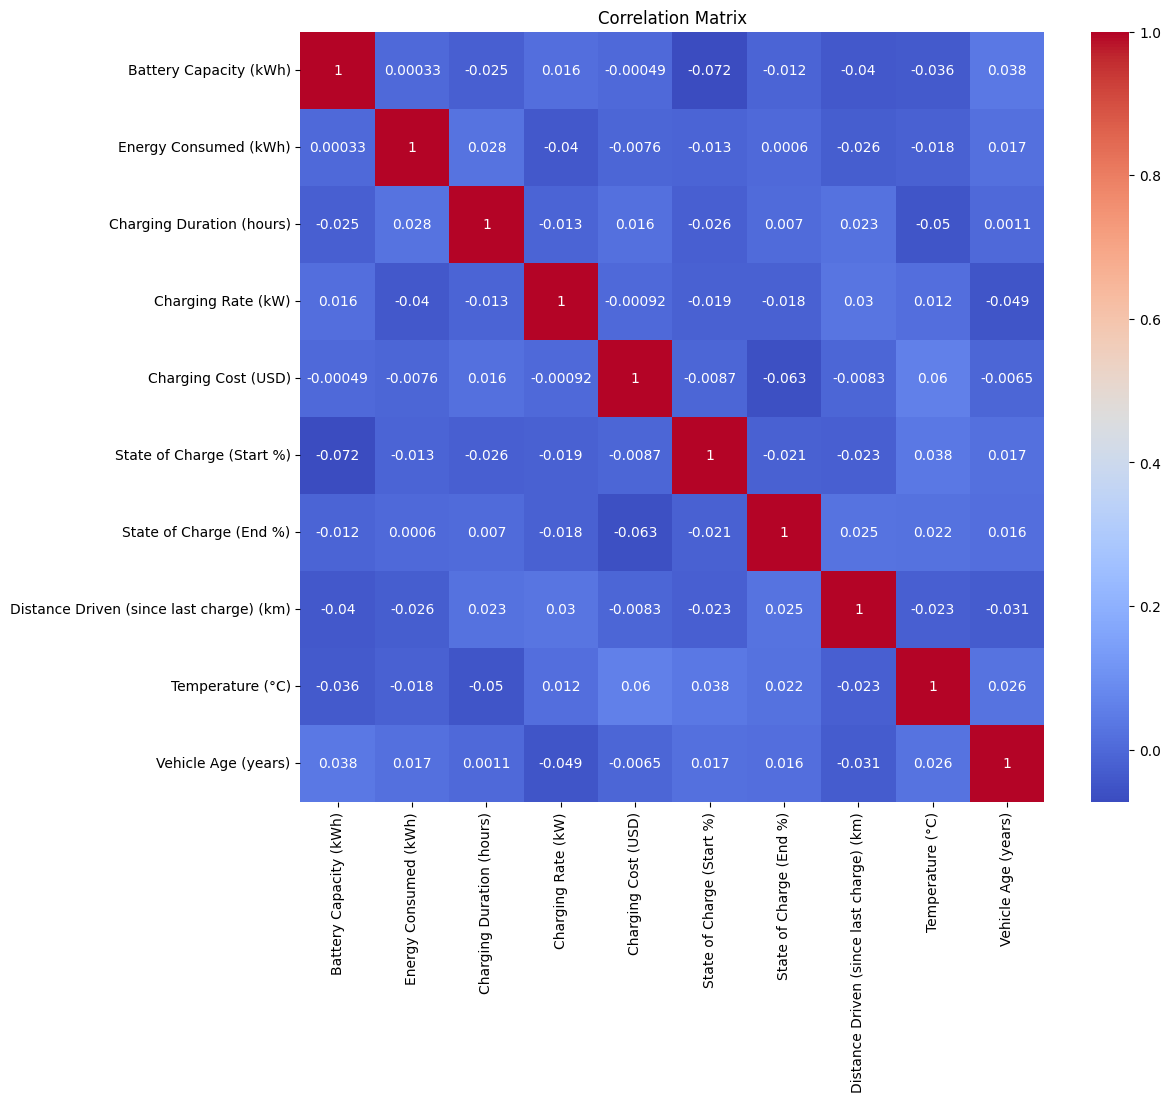

In [7]:
plt.figure(figsize=(12, 10))
corr_matrix = df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

> **b. Visualizations**

> i. Charging Sessions Over Time

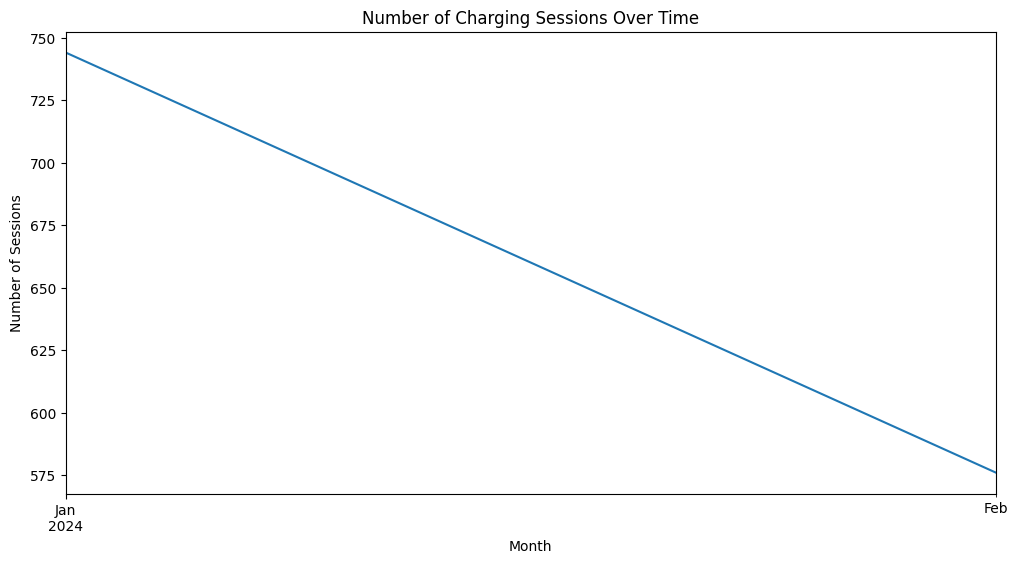

In [8]:
df['Month'] = df['Charging Start Time'].dt.to_period('M')
sessions_per_month = df.groupby('Month').size()

plt.figure(figsize=(12,6))
sessions_per_month.plot(kind='line')
plt.title('Number of Charging Sessions Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Sessions')
plt.show()

> ii. Distribution of Charging Costs

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


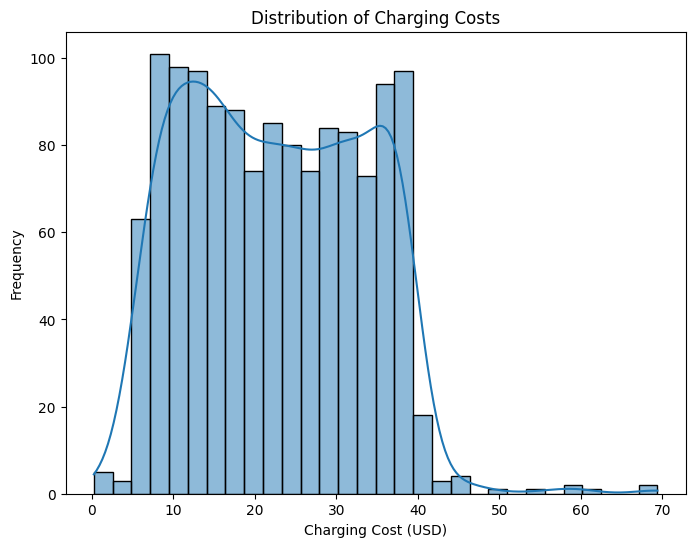

In [9]:
plt.figure(figsize=(8,6))
sns.histplot(df['Charging Cost (USD)'], bins=30, kde=True)
plt.title('Distribution of Charging Costs')
plt.xlabel('Charging Cost (USD)')
plt.ylabel('Frequency')
plt.show()


> iii. Charging Duration by Charger Type

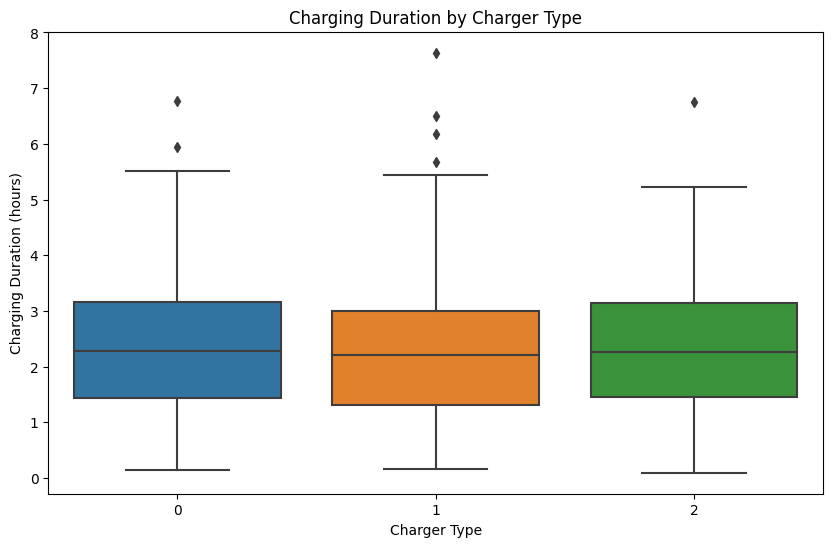

In [10]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Charger Type', y='Charging Duration (hours)', data=df)
plt.title('Charging Duration by Charger Type')
plt.xlabel('Charger Type')
plt.ylabel('Charging Duration (hours)')
plt.show()

> iv. Energy Consumed vs. Distance Driven

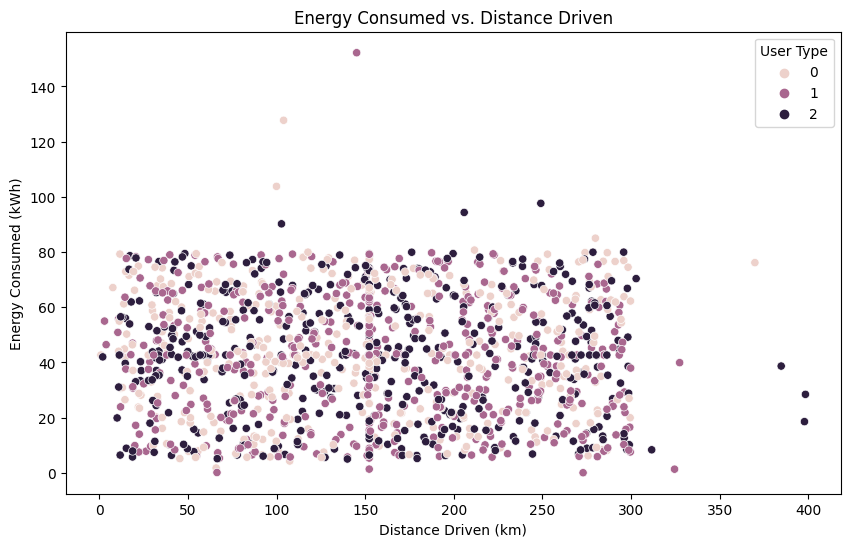

In [11]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='Distance Driven (since last charge) (km)', y='Energy Consumed (kWh)', hue='User Type', data=df)
plt.title('Energy Consumed vs. Distance Driven')
plt.xlabel('Distance Driven (km)')
plt.ylabel('Energy Consumed (kWh)')
plt.show()

**Predictive Modeling**

Charging Cost Prediction


Charging Cost Prediction - Random Forest Regressor
Mean Squared Error: 131.31
R-squared: -0.05


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


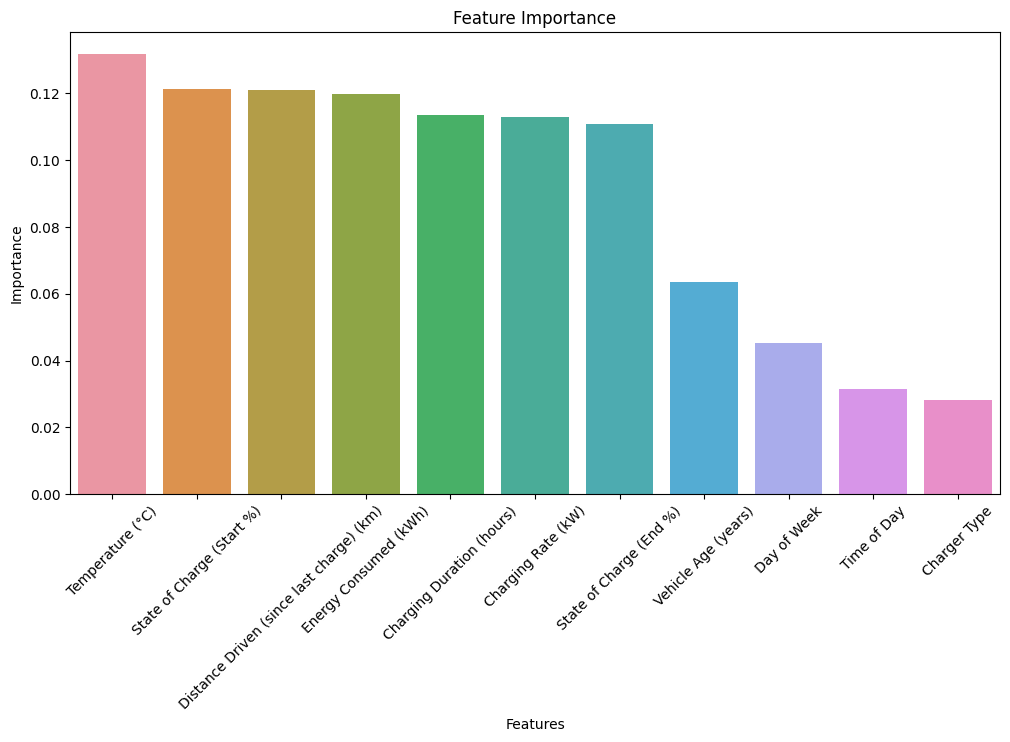

In [12]:
features = ['Energy Consumed (kWh)', 'Charging Duration (hours)', 'Charging Rate (kW)',
            'Charger Type', 'Time of Day', 'Day of Week', 'State of Charge (Start %)',
            'State of Charge (End %)', 'Distance Driven (since last charge) (km)',
            'Temperature (°C)', 'Vehicle Age (years)']

target = 'Charging Cost (USD)'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nCharging Cost Prediction - Random Forest Regressor")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
sns.barplot(x=[features[i] for i in indices], y=importances[indices])
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()


**Clustering and Segmentation**

**User Segmentation Using K-Means**

Group users based on their charging behaviors.

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

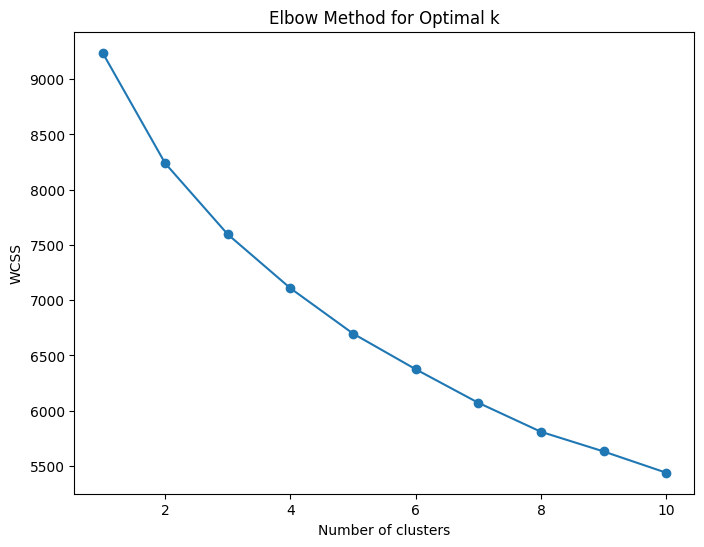

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


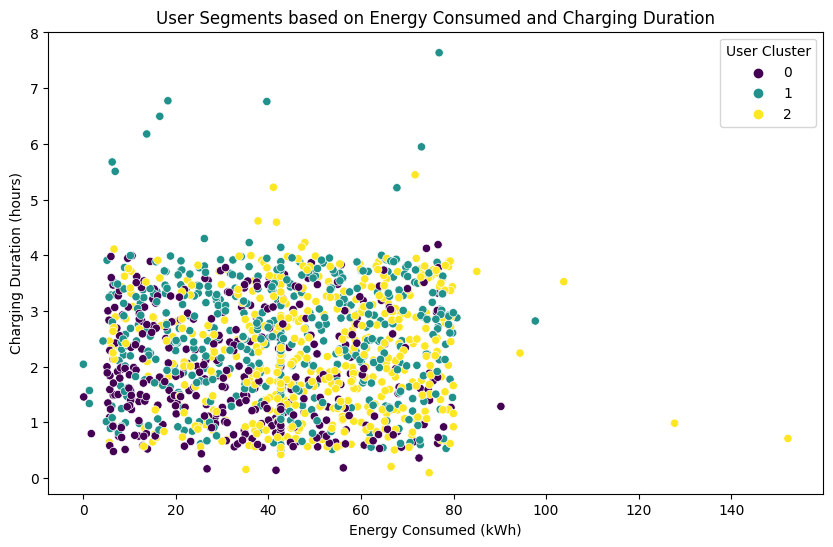

In [13]:
cluster_features = ['Energy Consumed (kWh)', 'Charging Duration (hours)', 'Charging Rate (kW)',
                    'Charging Cost (USD)', 'Distance Driven (since last charge) (km)',
                    'Temperature (°C)', 'Vehicle Age (years)']

X_cluster = df[cluster_features]
X_cluster_scaled = scaler.fit_transform(X_cluster)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_cluster_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,6))
plt.plot(range(1,11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df['User Cluster'] = kmeans.fit_predict(X_cluster_scaled)

plt.figure(figsize=(10,6))
sns.scatterplot(x='Energy Consumed (kWh)', y='Charging Duration (hours)', hue='User Cluster', data=df, palette='viridis')
plt.title('User Segments based on Energy Consumed and Charging Duration')
plt.xlabel('Energy Consumed (kWh)')
plt.ylabel('Charging Duration (hours)')
plt.show()


**Time Series Analysis**

**Forecasting Charging Sessions**

Using time series forecasting to predict future charging session counts.

/tmp/ipykernel_18/3779179581.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sessions = df.set_index('Charging Start Time').resample('M').size()


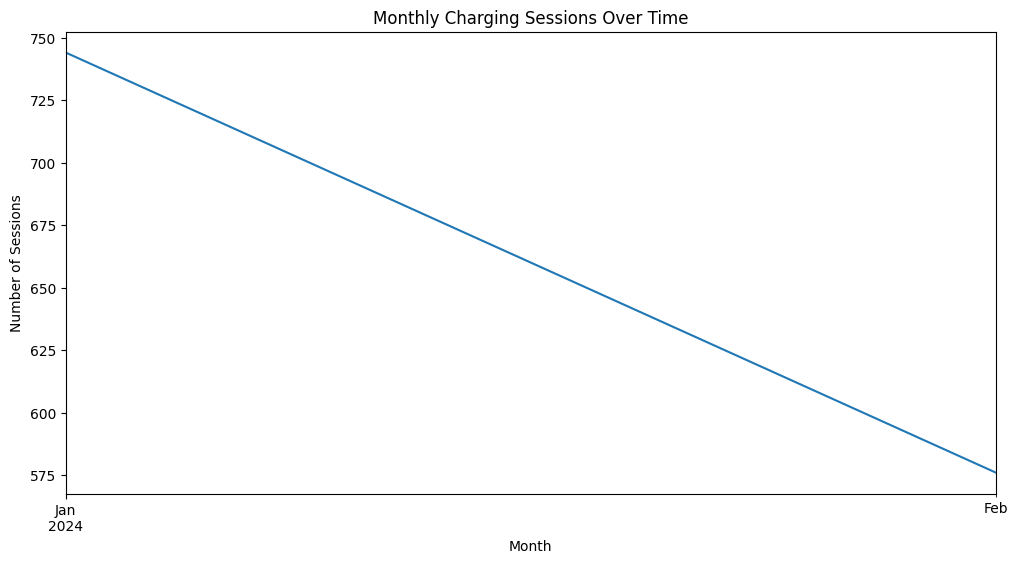

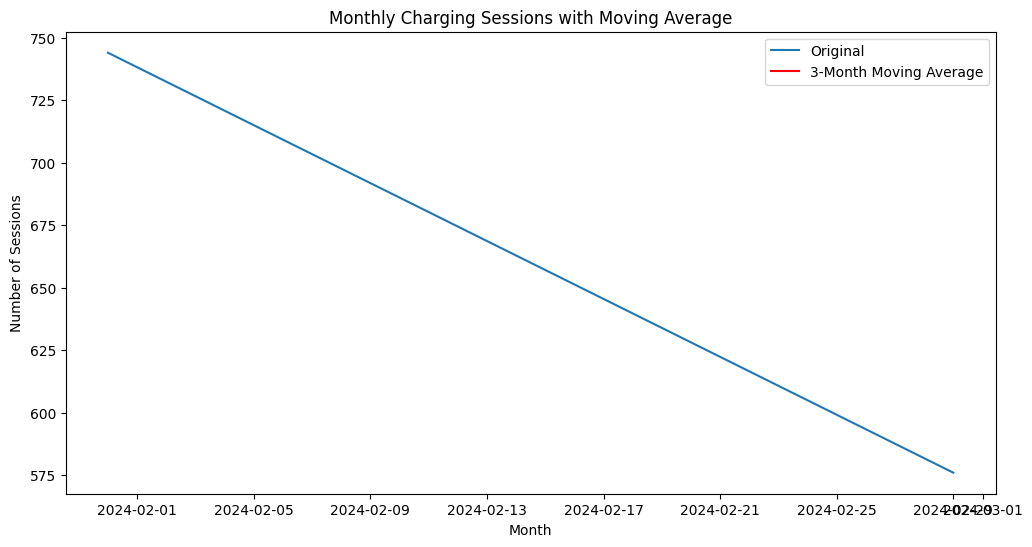

In [14]:
monthly_sessions = df.set_index('Charging Start Time').resample('M').size()

plt.figure(figsize=(12,6))
monthly_sessions.plot()
plt.title('Monthly Charging Sessions Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Sessions')
plt.show()

monthly_sessions_ma = monthly_sessions.rolling(window=3).mean()

plt.figure(figsize=(12,6))
plt.plot(monthly_sessions, label='Original')
plt.plot(monthly_sessions_ma, label='3-Month Moving Average', color='red')
plt.title('Monthly Charging Sessions with Moving Average')
plt.xlabel('Month')
plt.ylabel('Number of Sessions')
plt.legend()
plt.show()

/tmp/ipykernel_18/2442709049.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sessions = df.set_index('Charging Start Time').resample('M').size()



Monthly Sessions Data:
Charging Start Time
2024-01-31    744
2024-02-29    576
Freq: ME, dtype: int64

Type of monthly_sessions: <class 'pandas.core.series.Series'>
Shape of monthly_sessions: (2,)
IndexError encountered: too many indices for array: array is 0-dimensional, but 1 were indexed
This might be due to insufficient data or incorrect data formatting.


13:33:03 - cmdstanpy - INFO - Chain [1] start processing
13:33:03 - cmdstanpy - INFO - Chain [1] done processing
/opt/conda/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.hist

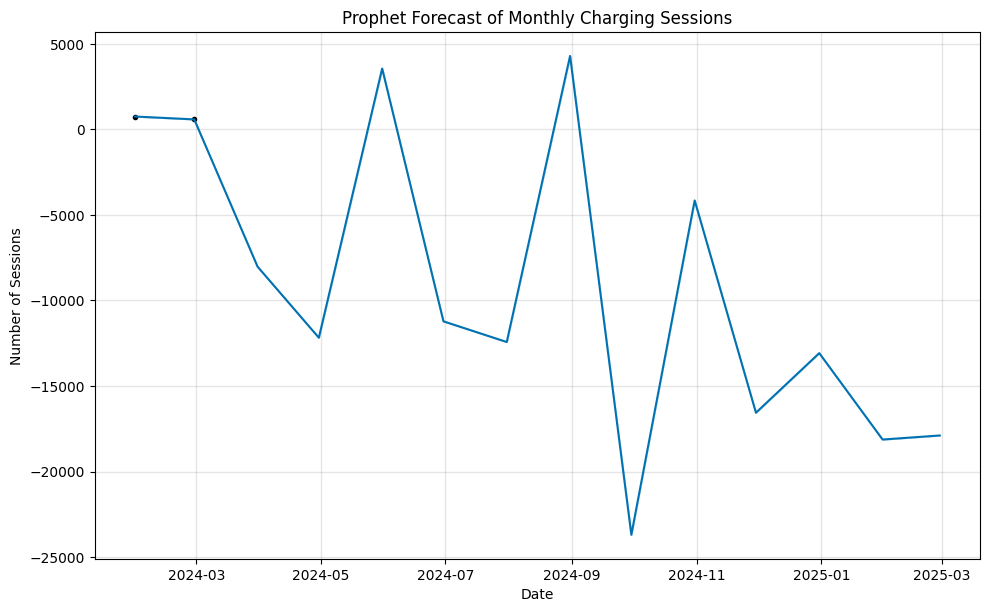

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

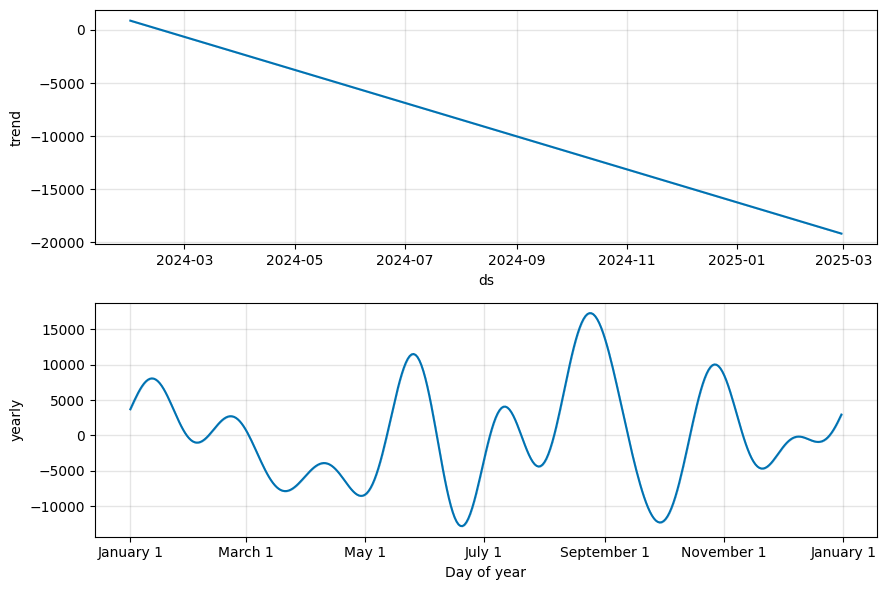

In [15]:
monthly_sessions = df.set_index('Charging Start Time').resample('M').size()

print("\nMonthly Sessions Data:")
print(monthly_sessions)

print("\nType of monthly_sessions:", type(monthly_sessions))
print("Shape of monthly_sessions:", monthly_sessions.shape)

if monthly_sessions.empty:
    print("Error: 'monthly_sessions' is empty. Please check your data.")
else:
    if len(monthly_sessions) < 24:
        print("Warning: Insufficient data points for reliable ARIMA modeling. Consider aggregating to a different frequency or collecting more data.")
    
    from statsmodels.tsa.arima.model import ARIMA

    try:
        model = ARIMA(monthly_sessions, order=(1,1,1))
        model_fit = model.fit()
        print(model_fit.summary())

        forecast = model_fit.forecast(steps=12)

        plt.figure(figsize=(12,6))
        plt.plot(monthly_sessions, label='Historical')
        plt.plot(forecast, label='Forecast', color='green')
        plt.title('Forecast of Monthly Charging Sessions')
        plt.xlabel('Month')
        plt.ylabel('Number of Sessions')
        plt.legend()
        plt.show()
    except IndexError as ie:
        print(f"IndexError encountered: {ie}")
        print("This might be due to insufficient data or incorrect data formatting.")
    except Exception as e:
        print(f"An error occurred while fitting the ARIMA model: {e}")

    try:
        from prophet import Prophet

        prophet_df = monthly_sessions.reset_index()
        prophet_df.columns = ['ds', 'y']  # Prophet expects 'ds' and 'y'

        model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
        model_prophet.fit(prophet_df)

        future = model_prophet.make_future_dataframe(periods=12, freq='M')

        forecast_prophet = model_prophet.predict(future)

        fig1 = model_prophet.plot(forecast_prophet)
        plt.title('Prophet Forecast of Monthly Charging Sessions')
        plt.xlabel('Date')
        plt.ylabel('Number of Sessions')
        plt.show()

        fig2 = model_prophet.plot_components(forecast_prophet)
        plt.show()
    except Exception as e:
        print(f"An error occurred while using Prophet for forecasting: {e}")

**Anomaly Detection**


Number of anomalies detected: 14


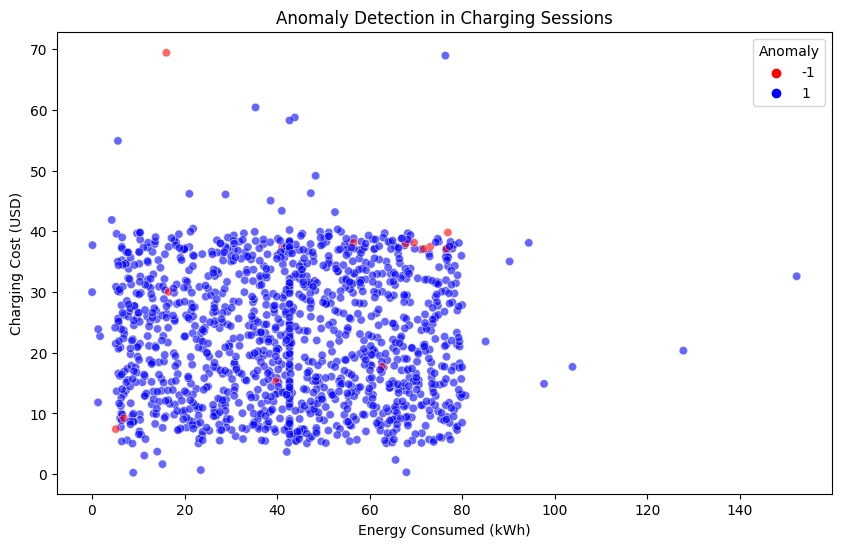

In [16]:
from sklearn.ensemble import IsolationForest

anomaly_features = ['Energy Consumed (kWh)', 'Charging Duration (hours)', 'Charging Rate (kW)',
                    'Charging Cost (USD)', 'Distance Driven (since last charge) (km)',
                    'Temperature (°C)', 'Vehicle Age (years)']

X_anomaly = df[anomaly_features]
X_anomaly_scaled = scaler.fit_transform(X_anomaly)

iso_forest = IsolationForest(contamination=0.01, random_state=42)
df['Anomaly'] = iso_forest.fit_predict(X_anomaly_scaled)

anomalies = df[df['Anomaly'] == -1]

print(f"\nNumber of anomalies detected: {len(anomalies)}")

plt.figure(figsize=(10,6))
sns.scatterplot(x='Energy Consumed (kWh)', y='Charging Cost (USD)', hue='Anomaly', data=df, palette=['red', 'blue'], alpha=0.6)
plt.title('Anomaly Detection in Charging Sessions')
plt.xlabel('Energy Consumed (kWh)')
plt.ylabel('Charging Cost (USD)')
plt.show()


**Optimization Studies**

**Charger Deployment Optimization**

Recommendation: Locations with high session counts might benefit from additional chargers or upgraded infrastructure, while those with low counts might need promotional efforts or reevaluation.

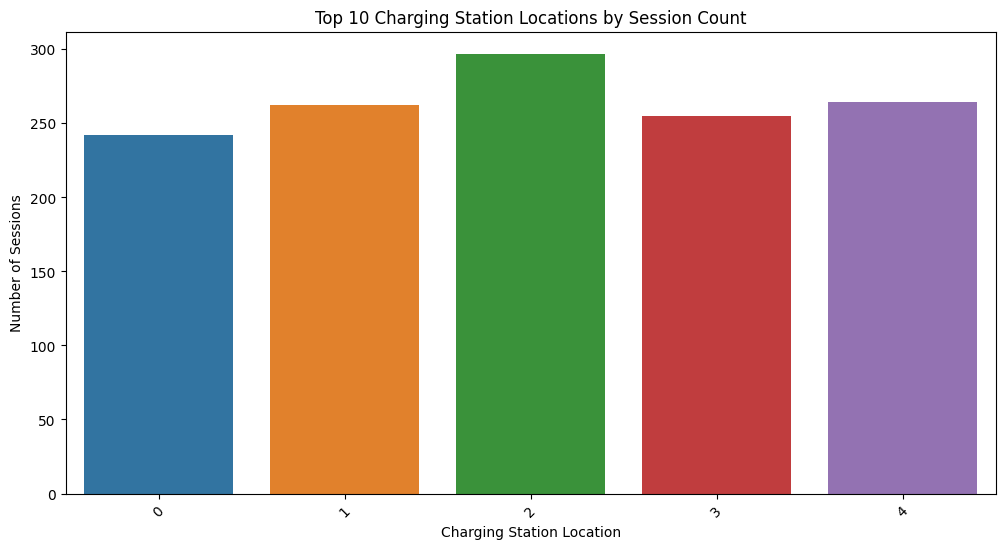

In [17]:
sessions_per_location = df['Charging Station Location'].value_counts().reset_index()
sessions_per_location.columns = ['Charging Station Location', 'Session Count']

plt.figure(figsize=(12,6))
sns.barplot(x='Charging Station Location', y='Session Count', data=sessions_per_location.head(10))
plt.title('Top 10 Charging Station Locations by Session Count')
plt.xlabel('Charging Station Location')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=45)
plt.show()


**Saving Processed Data and Models**

In [18]:
df.to_csv('ev_charging_data_processed.csv', index=False)

import joblib
joblib.dump(rf, 'charging_cost_rf_model.pkl')

['charging_cost_rf_model.pkl']

**Conclusion**


This notebook provides a foundational framework for analyzing EV charging data, offering initial insights into the dataset. Depending on your specific goals and the characteristics of your data, further customization and expansion of these analyses may be required. Here are a few suggested next steps:

**Advanced Modeling**: Consider experimenting with more advanced machine learning models such as Gradient Boosting, XGBoost, or neural networks to enhance predictive accuracy.

**Segment-Specific Analysis**: Dive deeper into the identified user segments to offer tailored services or develop more targeted marketing strategies.

**Data Integration**: Enrich your analysis by integrating external data sources such as traffic patterns, weather conditions, or economic indicators.

**Real-Time Dashboards**: Build interactive dashboards using tools like Streamlit or Dash to enable real-time monitoring and more dynamic decision-making.